<a href="https://colab.research.google.com/github/tsido/LDA-T307-project/blob/main/na_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Teemu Sidoroff (teemu.sidoroff@helsinki.fi)            2023-05-16

---


# Number agreement in BERT

## Introduction

This project looks into the syntactical capabilities of pre-trained BERT models. The project reproduces the 
experiments of subject verb number agreement tasks. 

The experiment is based on the material and prior research by Yoav Goldberg ([2019](https://arxiv.org/abs/1901.05287)) which studies
how BERT captures the subject-verb agreement by masking the verb in question and evaluating how accurately
the model selects the verb with correct form (plural vs singular) in the masked word prediction. As an addition to Goldberg's work my 
aim is to apply the same method by inverting the task by masking the subject word instead of the verb and compare the 
results between the two.


## Datasets 

Goldberg investigated the task using three different data sets. I use two of these datasets and create
another version of the sets where the subject noun is masked instead of the verb. This allows the comparison of 
the performance of the model between the two tasks.

The first dataset consists of around 30,000 sentences. In addition to the sentences and information of the masked verb the dataset includes information of how many attractors (i.e. other nouns between the subject and the verb) the sentences contains. The number of attractors ranges from 1 to 4 in the dataset. This dataset is referred as the large dataset in this notebook. 

The second dataset is a smaller one, consisting of nonsensical but syntactically correct sentences with 0 to 2 attractors in each. This dataset is considerably smaller, consisting only of 380 sentences. The idea of using these nonce sentences is to avoid the model from using semantic cues, but rely on syntactical information for the task instead. The dataset is referred as nonce dataset in the following.

## Method

To generate the subject masked versions of the datasets, I use [spaCy](https://spacy.io/) library to identify the subject for the sentences. This parsing step can introduce some bias into the data, as the
parser fails to parse all sentences correctly. For generating
the plural or singular version of the noun I used the [pattern](https://www.digiasset.org/html/pattern.html) library. 

I limited the study to investigate the results of only a single model, namely the [BERT base model](https://huggingface.co/bert-base-cased). 

The following section of this notebook contain the experiment code that can be replayed by re-running this notebook.

The results of the experiment are discussed below in the following sections.
* [Results for the large dataset](#large-dataset-results)
* [Results for the nonce dataset](#nonce-results)


## Experiment code



In [2]:
# avoid spam
%%capture

!pip install transformers
!pip install pattern


In [3]:
import pandas as pd
from transformers import PreTrainedModel, PreTrainedTokenizer,BertTokenizer, BertModel,BertForMaskedLM
from transformers import pipeline
import torch


In [4]:
%%capture
!mkdir data
# These are copies of the datasets by Goldberg, also available at https://github.com/yoavg/bert-syntax
!wget --output-document data/generated.tab https://tsido.lucid.fi/approaches_to_nlu/data/generated.tab
!wget --output-document data/lgd_dataset.tsv https://tsido.lucid.fi/approaches_to_nlu/data/lgd_dataset.tsv
!wget --output-document data/nonce_dataset.csv https://tsido.lucid.fi/approaches_to_nlu/data/nonce_dataset.csv

In [5]:
%%capture
# Initialize the model and tokenizer utlized in the experiments
model = BertForMaskedLM.from_pretrained('bert-base-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
# Linzen Goldberg dataset (=large dataset): ~30k sentences with 1-4 attractors
df = pd.read_table('data/lgd_dataset.tsv', header=None, names=['attractors', 'full_sentence', 'verb_masked_sentence', 'verb_true_label', 'verb_false_label'])

df['verb_masked_sentence'] = df['verb_masked_sentence'].apply(lambda x : x.replace("***mask***", "[MASK]"))
df[['attractors','full_sentence', 'verb_masked_sentence', 'verb_true_label','verb_false_label']].sample(2)


,attractors,full_sentence,verb_masked_sentence,verb_true_label,verb_false_label
12711,1,nearby craters of note include moseley just to...,nearby craters of note [MASK] moseley just to ...,include,includes
9770,2,"in the first books of the series , she is a fi...","in the first books of the series , she is a fi...",find,finds


In [7]:
import math

# the dataframe is called sample_df since during implementation
# I used a small subset of the data. Leaving the naming as is even
# when using the full data set
# Running with 30k row dataset and GPU this takes some 8 minutes in Google Colab
#sample_df = df.sample(300)
sample_df = df

# extract the logits for the singular and plural version 
# for the word in the masked position of a sentence
def get_label_probs(row, pos):
  if (pos == 'verb'):
    masked_sentence = row['verb_masked_sentence'] 
    true_label = row['verb_true_label']
    false_label = row['verb_false_label']
  else:
    masked_sentence = row['subject_masked_sentence'] 
    true_label = row['subject_true_label']
    false_label = row['subject_false_label']


  # skip sentences we failed to parse (happens in the noun masking case) 
  if (masked_sentence == None):
    return (float('nan'), float('nan'), float('nan'))

  # tokenize the text
  encoded_input = tokenizer(masked_sentence, return_tensors='pt').to(device)
    
  output = model(**encoded_input)

  # extract the index for the [MASK] token
  input_ids = encoded_input['input_ids'].squeeze().tolist()
  mask_index = input_ids.index(tokenizer.mask_token_id)

  true_label_id, false_label_id=tokenizer.convert_tokens_to_ids([true_label, false_label])
  true_label_p = output[0][0][mask_index][true_label_id].item()
  false_label_p = output[0][0][mask_index][false_label_id].item()

  return (true_label_p, false_label_p, true_label_p > false_label_p)

# prefix results with 'verb_' for the masked verb experiment
sample_df[['verb_true_label_p', 'verb_false_label_p', 'verb_is_accurate']] = sample_df.apply(lambda x: get_label_probs(x, 'verb'), axis=1, result_type='expand')

sample_df.to_csv('verb_number_agreement_with_results.csv')
# TODO persist the dataset for easy access of results

In [8]:

# create versions of the sentences where the **subject** is masked and re-create the experiment

# To do the subject masking, do the following:
# - parse the full sentences with spacy and identify the first subject
# - create subject masked version of the sentence and do the same comparison as with the verb case

import os
import spacy
from pattern.en import pluralize, singularize

SUBJECT_NOT_FOUND_FILE = "subject_not_found_dump.csv"
DEBUG = False

nlp = spacy.load('en_core_web_sm')

def get_subject(sentence):
    doc = nlp(sentence)
    for token in doc:
        if token.dep_ == 'nsubj':
            return token.text
    return None


def isplural(word):
     singular = singularize(word)
     return False if word == singular else True

# return the masked sentence and the subject and the singular and plural subjects
def generate_subject_data(row):
    sentence = row['full_sentence']
    subject = get_subject(sentence)
    if (subject):
        masked_sentence = sentence.replace(subject, '[MASK]')

        singular = singularize(subject) if (isplural(subject)) else subject
        plural = pluralize(subject) if (not isplural(subject)) else subject

        false_label = plural if singular == subject else singular
        true_label = singular if singular == subject else plural

        return (subject, masked_sentence, true_label, false_label)
    else:
        if DEBUG: print("No subject found:", sentence)
        #store the whole row into a separate file for manual inspection
        row.to_frame().T.to_csv(SUBJECT_NOT_FOUND_FILE, mode='a', header=False, index=False)
        return (None, None, None, None)     


# write the discarded sentences into a file, remove existing file first
# for later inspection
if os.path.exists(SUBJECT_NOT_FOUND_FILE):
    os.remove(SUBJECT_NOT_FOUND_FILE)
empty_df = pd.DataFrame(columns=df.columns)
# write the header for the CSV
empty_df.to_csv(SUBJECT_NOT_FOUND_FILE, header=True, index=False)

sample_df[['subject', 'subject_masked_sentence', 'subject_true_label', 'subject_false_label']] = sample_df.apply(generate_subject_data, axis=1, result_type='expand')
# drop data that was failed rows 
sample_df = sample_df.dropna()


In [9]:
sample_df[['subject_true_label_p', 'subject_false_label_p', 'subject_is_accurate']] = sample_df.apply(lambda x: get_label_probs(x, 'subject'), axis=1, result_type='expand')

#persist the dataset for easy access of results
# NOTE: this file is also uploaded offline for easier access when compling
# results
sample_df.to_csv('subject_number_agreement_with_results.csv')


<ipython-input-9-29f24d8bb0c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[['subject_true_label_p', 'subject_false_label_p', 'subject_is_accurate']] = sample_df.apply(lambda x: get_label_probs(x, 'subject'), axis=1, result_type='expand')
<ipython-input-9-29f24d8bb0c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[['subject_true_label_p', 'subject_false_label_p', 'subject_is_accurate']] = sample_df.apply(lambda x: get_label_probs(x, 'subject'), axis=1, result_type='expand')
<ipyth

In [10]:
# Calculate the results for the nonce dataset
nonce_df = pd.read_csv('data/nonce_dataset.csv')

nonce_df[['verb_true_label_p', 'verb_false_label_p', 'verb_is_accurate']] = nonce_df.apply(lambda x: get_label_probs(x, 'verb'), axis=1, result_type='expand')


In [11]:
nonce_df[['subject', 'subject_masked_sentence', 'subject_true_label', 'subject_false_label']] = nonce_df.apply(generate_subject_data, axis=1, result_type='expand')
nonce_df = nonce_df.dropna()
nonce_df[['subject_true_label_p', 'subject_false_label_p', 'subject_is_accurate']] = nonce_df.apply(lambda x: get_label_probs(x, 'subject'), axis=1, result_type='expand')

nonce_df.to_csv('number_agreement_nonce_with_results.csv')


## <a name="large-dataset-results"></a>Results of the large dataset

In [12]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# NOTE: You can start running the notebook from here in order to avoid the 
# slow result processing

# download resultfiles if it doesn't exist
! [ ! -f subject_number_agreement_with_results.csv ] && wget https://tsido.lucid.fi/approaches_to_nlu/data/subject_number_agreement_with_results.csv


In [13]:
# Reload the results so we don't need to run the model inference every time

import pandas as pd
result_df = pd.read_csv('subject_number_agreement_with_results.csv')



In [14]:


print("Accuracy of BERT with Linzen Goldberg dataset by attractors:")
results = result_df.groupby('attractors')[['verb_is_accurate', 'subject_is_accurate']].mean()
results

Accuracy of BERT with Linzen Goldberg dataset by attractors:


,verb_is_accurate,subject_is_accurate
attractors,,
1,0.955277,0.901920
2,0.948118,0.881772
3,0.941935,0.854839
4,0.928287,0.864542


In [15]:

# Filter the results where the logits for true and false are equal, as those indicate that the token is unknown
filtered_results = result_df[(result_df['subject_true_label_p'] != result_df['subject_false_label_p']) & (result_df['verb_true_label_p'] != result_df['verb_false_label_p'])]
print("Accuracy of BERT with Linzen Goldberg dataset by attractors with unknown tokens filtered:")
accuracy_results = filtered_results.groupby('attractors')[['verb_is_accurate', 'subject_is_accurate']].mean()
accuracy_results

Accuracy of BERT with Linzen Goldberg dataset by attractors with unknown tokens filtered:


,verb_is_accurate,subject_is_accurate
attractors,,
1,0.959031,0.960777
2,0.954959,0.940684
3,0.947674,0.923256
4,0.952174,0.934783


In [16]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

print("Sentences where both verb and subject is incorrectly chosen by the model:")
data = filtered_results[(filtered_results['subject_is_accurate'] == False) & (filtered_results['verb_is_accurate'] == False)]
data_table.DataTable(data, include_index=False, num_rows_per_page=5)


Sentences where both verb and subject is incorrectly chosen by the model:


,Unnamed: 0,attractors,full_sentence,verb_masked_sentence,verb_true_label,verb_false_label,verb_true_label_p,verb_false_label_p,verb_is_accurate,subject,subject_masked_sentence,subject_true_label,subject_false_label,subject_true_label_p,subject_false_label_p,subject_is_accurate
122,126,1,"according to barsalou , simulation composed of...","according to barsalou , simulation composed of...",creates,create,3.418266,4.212551,False,simulation,"according to barsalou , [MASK] composed of the...",simulation,simulations,1.833017,1.904535,False
790,807,2,air force panel ( who were assigned as `` merc...,air force panel ( who were assigned as `` merc...,claims,claim,4.231212,5.418381,False,panel,air force [MASK] ( who were assigned as `` mer...,panel,panels,2.329565,3.139415,False
1031,1055,2,all rulings after 1570 as king of hungary refe...,all rulings after 1570 as king of hungary refe...,refer,refers,2.357046,4.353528,False,rulings,all [MASK] after 1570 as king of hungary refer...,rulings,ruling,0.777411,5.986384,False
1072,1097,1,all the different fonts and color tend to thro...,all the different fonts and color [MASK] to th...,tend,tends,5.079307,6.851832,False,fonts,all the different [MASK] and color tend to thr...,fonts,font,-0.904954,6.012044,False
1450,1484,2,although the record and names of their childre...,although the record and names of their childre...,shows,show,8.341554,8.785891,False,record,although the [MASK] and names of their childre...,record,records,7.086719,9.268765,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28221,28778,3,update that fixes issues with limited games an...,update that fixes issues with limited games an...,makes,make,13.074266,15.345674,False,fixes,update that [MASK] issues with limited games a...,fixes,fix,0.952856,7.454342,False
28373,28933,1,usually these group of people goes around at n...,usually these group of people [MASK] around at...,goes,go,6.570880,10.423776,False,group,usually these [MASK] of people goes around at ...,group,groups,12.927755,13.057397,False
28668,29236,1,weak keep it is referred to a lot by various w...,weak keep it is referred to a lot by various w...,gets,get,4.836196,6.246789,False,lifestyle,weak keep it is referred to a lot by various w...,lifestyle,lifestyles,0.758718,0.990094,False
28671,29239,1,"weak oppose slanted posts , glare on the hat ,...","weak oppose slanted posts , glare on the hat ,...",looks,look,3.129375,3.430743,False,weak,"[MASK] oppose slanted posts , glare on the hat...",weak,weaks,-1.480049,2.497913,False


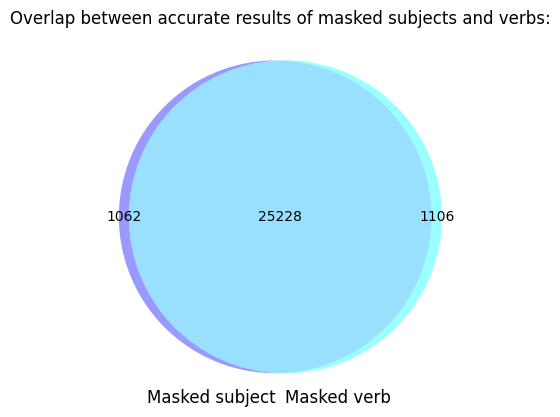

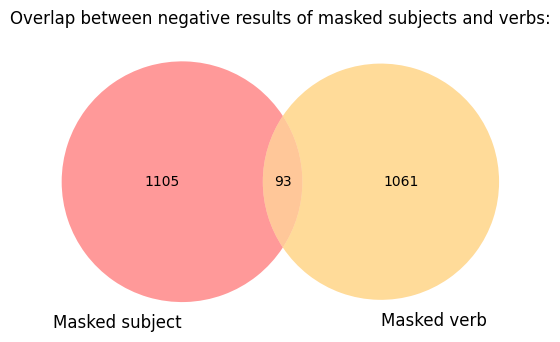

In [17]:
# Visualize the overlap of the results using Venn diagrams
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# accurate predictions from masked subject experiments:
subjects_correct = filtered_results['full_sentence'].where(filtered_results['subject_is_accurate'] == True).tolist()
verbs_correct = filtered_results['full_sentence'].where(filtered_results['verb_is_accurate'] == True).tolist()

venn2([set(subjects_correct), set(verbs_correct)], set_colors=['blue', 'cyan'], set_labels=['Masked subject', 'Masked verb'])
plt.title('Overlap between accurate results of masked subjects and verbs:')
plt.show()

subjects_incorrect = filtered_results.index[filtered_results['subject_is_accurate'] == False].tolist()
verbs_incorrect = filtered_results.index[filtered_results['verb_is_accurate'] == False].tolist()
venn2([set(subjects_incorrect), set(verbs_incorrect)], set_colors=['red', 'orange'], set_labels=['Masked subject', 'Masked verb'])
plt.title('Overlap between negative results of masked subjects and verbs:')
plt.show()



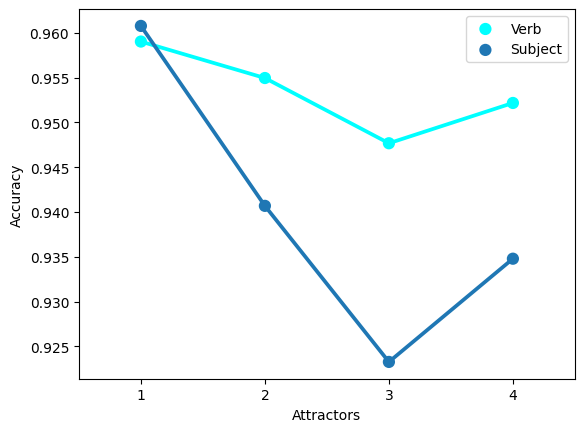

In [18]:
import seaborn as sns

sns.pointplot(filtered_results, x='attractors', y='verb_is_accurate', errorbar=None, color='cyan', label='Verb')
ax = sns.pointplot(filtered_results, x='attractors', y='subject_is_accurate', errorbar=None, label='Subject')
ax.set(ylabel='Accuracy', xlabel='Attractors')
ax.legend()

## <a name="nonce-dataset-results"></a>Results of the nonce dataset

In [27]:
%%capture
# Reload the results so we don't need to run the model inference every time
! [ ! -f number_agreement_nonce_with_results.csv ] && wget https://tsido.lucid.fi/approaches_to_nlu/data/number_agreement_nonce_with_results.csv

import pandas as pd
nonce_df = pd.read_csv('number_agreement_nonce_with_results.csv')

In [41]:
filtered_nonce_results = nonce_df[(nonce_df['subject_true_label_p'] != nonce_df['subject_false_label_p']) & (nonce_df['verb_true_label_p'] != nonce_df['verb_false_label_p'])]
unfiltered_nonce_results = nonce_df
print(len(unfiltered_nonce_results))
print(len(filtered_nonce_results))
print('Shared logits for subjects', len(unfiltered_nonce_results.query('subject_true_label_p == subject_false_label_p')))
print('Shared logits for verbs', len(unfiltered_nonce_results.query('verb_true_label_p == verb_false_label_p')))

results = filtered_nonce_results[['verb_is_accurate', 'subject_is_accurate']].mean()
results


359
274
Shared logits for subjects 80
Shared logits for verbs 5


verb_is_accurate       0.817518
subject_is_accurate    0.795620
dtype: float64

In [25]:
data = filtered_nonce_results[(filtered_nonce_results['subject_is_accurate'] == False) & (filtered_nonce_results['verb_is_accurate'] == False)]
data_table.DataTable(data, include_index=False, num_rows_per_page=5)


,Unnamed: 0.1,Unnamed: 0,full_sentence,verb_masked_sentence,verb_true_label,verb_false_label,verb_true_label_p,verb_false_label_p,verb_is_accurate,subject,subject_masked_sentence,subject_true_label,subject_false_label,subject_true_label_p,subject_false_label_p,subject_is_accurate
54,55,126,the electoral parties we tolerate in our label...,the electoral parties we tolerate in our label...,assume,assumes,-5.141294,-4.430453,False,parties,the electoral [MASK] we tolerate in our label ...,parties,party,5.001207,5.211483,False
56,57,130,Because of the spreadsheet that his hostile to...,Because of the spreadsheet that his hostile to...,ensures,ensure,-2.902240,-0.632169,False,hostile,Because of the spreadsheet that his [MASK] tom...,hostile,hostiles,-2.589787,-0.680003,False
66,67,150,the electrostatic fisheries we develop in our ...,the electrostatic fisheries we develop in our ...,exist,exists,-1.461376,-0.624074,False,fisheries,the electrostatic [MASK] we develop in our mon...,fisheries,fishery,-0.124862,0.933351,False
126,129,282,The historical voting movements wash there ope...,The historical voting movements wash there [MA...,operates,operate,-4.160288,-3.440489,False,movements,The historical voting [MASK] wash there operat...,movements,movement,-0.854700,1.717710,False
172,178,388,The interested popularity to reconsider for la...,The interested popularity to reconsider for la...,ensures,ensure,-2.401338,-1.728330,False,ensures,The interested popularity to reconsider for la...,ensures,ensure,-2.401338,-1.728330,False
181,187,408,the academic grandparents we proceed in our ch...,the academic grandparents we proceed in our ch...,enjoy,enjoys,-0.036061,0.482687,False,grandparents,the academic [MASK] we proceed in our channel ...,grandparents,grandparent,-5.555443,1.407114,False
282,291,642,The joint lot cases recommend there adds raid ...,The joint lot cases recommend there [MASK] rai...,adds,add,0.311989,2.909750,False,cases,The joint lot [MASK] recommend there adds raid...,cases,case,0.075195,0.837249,False
286,295,650,My yoga with answering the throat technically ...,My yoga with answering the throat technically ...,observes,observe,-3.396935,-0.763799,False,yoga,My [MASK] with answering the throat technicall...,yoga,yogas,-1.642658,-1.042765,False
356,366,814,The obsessed coding I built actually from them...,The obsessed coding I built actually from them...,extends,extend,-2.540220,-2.483209,False,coding,The obsessed [MASK] I built actually from them...,coding,codings,-2.048849,1.359644,False


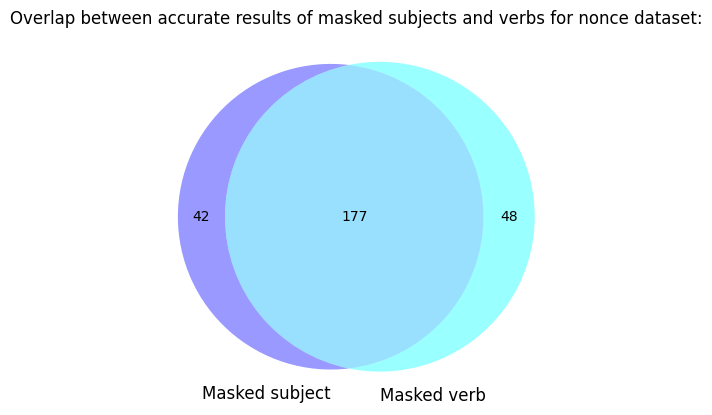

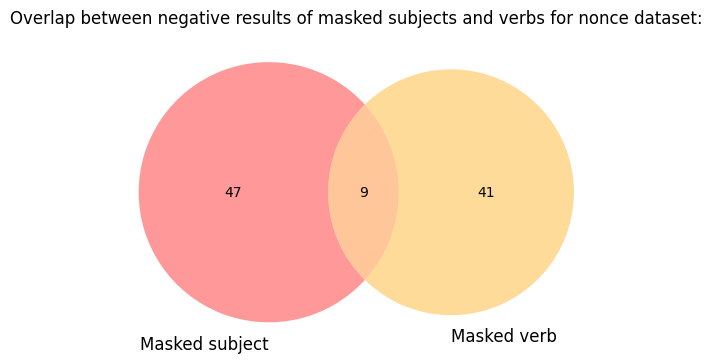

In [28]:
# Visualize the overlap of the results using Venn diagrams
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# accurate predictions from masked subject experiments for nonce senntences:
subjects_correct = filtered_nonce_results['full_sentence'].where(filtered_nonce_results['subject_is_accurate'] == True).tolist()
verbs_correct = filtered_nonce_results['full_sentence'].where(filtered_nonce_results['verb_is_accurate'] == True).tolist()

venn2([set(subjects_correct), set(verbs_correct)], set_colors=['blue', 'cyan'], set_labels=['Masked subject', 'Masked verb'])
plt.title('Overlap between accurate results of masked subjects and verbs for nonce dataset:')
plt.show()

subjects_incorrect = filtered_nonce_results.index[filtered_nonce_results['subject_is_accurate'] == False].tolist()
verbs_incorrect = filtered_nonce_results.index[filtered_nonce_results['verb_is_accurate'] == False].tolist()
venn2([set(subjects_incorrect), set(verbs_incorrect)], set_colors=['red', 'orange'], set_labels=['Masked subject', 'Masked verb'])
plt.title('Overlap between negative results of masked subjects and verbs for nonce dataset:')
plt.show()

## Discussion of the results

* The errors for verbs and subjects are mainly made in different sentences. Of total of 2259 errors only 93 are made in both subject and verb case in the large dataset and of 97 total errors only 9 are shared in the nonce dataset.
* The correct masked verb is predicted with a slighty higher accuracy than subject in both datasets. 
* The number of attractors lowers the accuracy in the case of subjects
* The probabilities for many of the candidate subjects and verbs are equal for the true and false labels. This is because words are not found as individual tokens and are labeled as `[UNK]` tokens instead. The vast majority of these cases are in the masked subject experiment.  
  * In the large dataset:
    * There are 103 (5.4%) cases of these for verbs
    * And 1817 (94.6%) cases for subjects
  * In the nonce dataset:
    * 5 (5.9%) cases for verbs
    * 80 (94.1%) for subjects
  * These uknown tokens likely skew the results somewhat
* The results for masked verbs are few percent lower than in the original experiment. A different model was used, `bert-base-cased` vs `bert-base-uncased`, that could explain it.


## Conclusions 

TODO
Further ideas: 
* redo the experiment with a test set from a treebank that has been manually annotated. This can lift some uncertainty from the masked subject experiments. 
* Experiment with other languages than english